# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
    '''Takes in a number of training examples and prints the text of the message along with the label'''
    # Iterating through each item in the range of training examples: 
    for item in range(num_examples):
      # Printing which example we are on:
      print("Training Example #" + str(item + 1))
      # Printing the text: 
      print("Message: " +  str(train_data[item]))
      # Printing the label: 
      print("Label:" + str(newsgroups_train.target_names[train_labels[item]]))
      # New line break for stylistic/clarity purposes: 
      print('\n')
    ### STUDENT END ###

Q1(5)

Training Example #1
Message: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Label:comp.graphics


Training Example #2
Message: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corrupt

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
    ### STUDENT START ###
    # Part 1: 
    print("Part #1: ")
    # Transforming the training data into a matrix of word unigram feature vectors using CountVectorization and its .fit_transform method. Use .nnz and .shape attributes, and .get_feature_names method:
    fit = CountVectorizer()
    transformed = fit.fit_transform(train_data)
    # Getting the size of the vocabulary: 
    size = np.shape(transformed)
    num_rows = size[0]
    num_columns = size[1]
    # Printing the size of the vocabulary:
    print("The vocabulary has " + str(num_rows) + " rows and " + str(num_columns) + " columns.")
    
    # Getting nonzero values: 
    example_nonzeros = transformed.getnnz(1)
    # Printing the average number of non-zero features per example:
    print("The average number of non-zero features per example is " +  str(np.sum(example_nonzeros)/len(example_nonzeros)))
    # Printing the fraction of the non-zero entries in the matrix:
    print("The fraction of the non-zero entries in the matrix is " + str(np.sum(example_nonzeros)/(num_rows*num_columns)))

    # Printing the 0th and last feature strings (in alphabetical order):
    feature_strings = sorted(fit.get_feature_names())
    zero_feature_strings = feature_strings[0]
    print("The 0th feature string is " + str(zero_feature_strings))
    last_feature_strings = feature_strings[-1]
    print("The last feature string is " + str(last_feature_strings))
    
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    # Part 2: 
    print('\n')
    print("Part #2: ")
    # Transforming the training data into a matrix of word unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"] using CountVectorization(vocabulary=...) and its .transform method:
    uni_gram_transformed = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"]).transform(train_data)
    # Getting the size of the vocabulary: 
    size = np.shape(uni_gram_transformed)
    num_rows = size[0]
    num_columns = size[1]  
    # Confirming the size of the vocabulary:
    print("The vocabulary has " + str(num_rows) + " rows and " + str(num_columns) + " columns.")
    # Printing the average number of non-zero features per example:
    example_nonzeros = uni_gram_transformed.getnnz(1)
    print("The average number of non-zero features per example is " +  str(np.sum(example_nonzeros)/len(example_nonzeros)))  
    
    # Part 3:
    print('\n')
    print("Part #3: ")
    # Transforming the training data into a matrix of character bigram and trigram feature vectors using CountVectorization(analyzer=..., ngram_range=...) and its .fit_transform method:
    bi_tri_gram_transformed = CountVectorizer(analyzer = "char_wb", ngram_range = (2,3)).fit_transform(train_data)
    # Getting the size of the vocabulary: 
    size = np.shape(bi_tri_gram_transformed)
    num_rows = size[0]
    num_columns = size[1]
    # Printing the size of the vocabulary:
    print("The vocabulary has " + str(num_rows) + " rows and " + str(num_columns) + " columns.")

    # Part 4:
    print('\n')
    print("Part #4: ")
    # Transforming the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents:
    pruned_transformed = CountVectorizer(min_df = 10).fit_transform(train_data)
    # Getting the size of the vocabulary: 
    size = np.shape(pruned_transformed)
    num_rows = size[0]
    num_columns = size[1]
    # Printing size of the vocabulary:
    print("The vocabulary has " + str(num_rows) + " rows and " + str(num_columns) + " columns.")

    # Part 5:
    print('\n')
    print("Part #5: ")
    # Initializing the vectorizer and then transforming the training data into a matrix of word unigram feature vectors:
    vectorizer = CountVectorizer()
    training = vectorizer.fit_transform(train_data)
    
    # Building vocabularies for both train and dev and looking at the size of the difference: 
    train_vocab = vectorizer.vocabulary_
    
    # Transforming the dev data:
    development = vectorizer.fit_transform(dev_data)
    # Building vocabularies for both train and dev and looking at the size of the difference: 
    dev_vocab = vectorizer.vocabulary_
    
    # For each item in development vocab, checking if it's missing from training vocab:
    # If it is, then incrementing the dev only counter: 
    dev_only = 0
    for item in dev_vocab:
        if item not in list(train_vocab.keys()):
            dev_only += 1
            
    # Printing the fraction of words in the development vocabulary that is missing from the training vocabulary:
    print("Fraction of words in the development vocabulary that is missing from the training vocabulary: " + 
          str(dev_only/len(dev_vocab)))
    ### STUDENT END ###

Q2()

Part #1: 
The vocabulary has 2034 rows and 26879 columns.
The average number of non-zero features per example is 96.70599803343165
The fraction of the non-zero entries in the matrix is 0.0035978272269590263
The 0th feature string is 00
The last feature string is zyxel


Part #2: 
The vocabulary has 2034 rows and 4 columns.
The average number of non-zero features per example is 0.26843657817109146


Part #3: 
The vocabulary has 2034 rows and 28954 columns.


Part #4: 
The vocabulary has 2034 rows and 3064 columns.


Part #5: 
Fraction of words in the development vocabulary that is missing from the training vocabulary: 0.24787640034470024


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
    ### STUDENT START ###
    # Transforming the training and development data to matrices of word unigram feature vectors using use CountVectorizer and its .fit_transform and .transform methods to transform data: 
    vectorizer = CountVectorizer()
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    
    print("Part 1: ")
    # Producing several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score using use KNeighborsClassifier(...) to produce a k-Nearest Neighbors model:
    k_values = np.arange(1, 27, 2)
    for k in k_values: 
        # Fitting the model on the transformed training data: 
        model = KNeighborsClassifier(n_neighbors = k).fit(train_transformed, train_labels)
        # Predicting with transformed dev data: 
        predictions = model.predict(dev_transformed)
        # For each model, showing the k value and f1 score:
        print("k value: " + str(k))
        # Using metrics.f1_score(..., average="weighted") to compute f1 score:
        print("f1 score: " + str(metrics.f1_score(dev_labels, predictions, average='weighted')))
        
    print('\n')
    # With the k set to optimize f1 score (k=7):
    optimal_k = 7
    # Creating a new model with the optimized k value and fitting on transformed training data: 
    optimized_model = KNeighborsClassifier(n_neighbors = optimal_k).fit(train_transformed, train_labels)
    # Predicting with transformed dev data: 
    prediction = optimized_model.predict(dev_transformed)
    # For the model, showing the k value and f1 score:
    print("optimal k value: " + str(optimal_k))
    # Using metrics.f1_score(..., average="weighted") to compute f1 score:
    print("optimal f1 score: " + str(metrics.f1_score(dev_labels, prediction, average='weighted')))
    print('\n')
        
    print("Part 2: ")
    # Producing several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score:
    alpha_values = list(range(10))
    for alpha in alpha_values:
        model = MultinomialNB(alpha=alpha).fit(train_transformed, train_labels)
        # Predicting with transformed dev data: 
        predictions = model.predict(dev_transformed)
        # For each model, showing the alpha value and f1 score: 
        print("alpha value: " + str(alpha))
        # Using metrics.f1_score(..., average="weighted") to compute f1 score:
        print("f1 score: " + str(metrics.f1_score(dev_labels, predictions, average='weighted')))
        
    print('\n')
    # With the alphta set to optimize f1 score (alpha=1):
    optimal_alpha = 1
    # Creating a new model with the optimized alpha value and fitting on transformed training data: 
    optimized_model = MultinomialNB(alpha=optimal_alpha).fit(train_transformed, train_labels)
    # Predicting with transformed dev data: 
    prediction = optimized_model.predict(dev_transformed)
    # For the model, showing the alpha value and f1 score: 
    print("optimal alpha value: " + str(optimal_alpha))
    # Using metrics.f1_score(..., average="weighted") to compute f1 score:
    print("optimal f1 score: " + str(metrics.f1_score(dev_labels, prediction, average='weighted')))
    print('\n')

    print("Part 3: ")
    # Producing several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score:
    # (Decided to test all values from 0.1 to 1 because this is where the accuracy was almost as high as with C=1000)
    C_values= [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 1000]
    for C in C_values:
        model = LogisticRegression(C = C).fit(train_transformed, train_labels)
        # Predicting with transformed dev data: 
        predictions = model.predict(dev_transformed)
        # For each model, show the C value, f1 score, and sum of squared weights for each topic:
        print("C value: " + str(C))
        # Using metrics.f1_score(..., average="weighted") to compute f1 score:
        print("f1 score: "  + str(metrics.f1_score(dev_labels, predictions, average='weighted')))
        # Squaring each item in the weights for each topic and summing to get the sum of squared weights for each topic to print out:
        squared_weights = []
        for item in model.coef_:
            squared_weights.append(item**2)
        print("Sum of squared weights for each topic:",sum(squared_weights))
        
    print('\n')
    # With the C set to optimize f1 score (C=1000):
    optimal_C = 1000
    # Creating a new model with the optimized C value and fitting on transformed training data: 
    optimized_model = LogisticRegression(C = optimal_C).fit(train_transformed, train_labels)
    # Predicting with transformed dev data:
    prediction = optimized_model.predict(dev_transformed)
    # Show the C value, f1 score, and sum of squared weights for each topic:
    print("optimal C value: " + str(optimal_C))
    # Using metrics.f1_score(..., average="weighted") to compute f1 score:
    print("optimal f1 score: "  + str(metrics.f1_score(dev_labels, prediction, average='weighted')))
    # Squaring each item in the weights for each topic and summing to get the sum of squared weights for each topic to print out:
    squared_weights = []
    for item in optimized_model.coef_:
        squared_weights.append(item**2)
    print("Sum of squared weights for each topic:", sum(squared_weights)) 
    
    ### STUDENT END ###

Q3()

Part 1: 
k value: 1
f1 score: 0.3805030018531525
k value: 3
f1 score: 0.4084150225437623
k value: 5
f1 score: 0.4287607236218357
k value: 7
f1 score: 0.45047910006117586
k value: 9
f1 score: 0.4365666176198027
k value: 11
f1 score: 0.4266108018696209
k value: 13
f1 score: 0.42404338833763805
k value: 15
f1 score: 0.4326339805547054
k value: 17
f1 score: 0.4485853212909305
k value: 19
f1 score: 0.4365794782510113
k value: 21
f1 score: 0.42609394906353587
k value: 23
f1 score: 0.40811738399495695
k value: 25
f1 score: 0.41610581482270387


optimal k value: 7
optimal f1 score: 0.45047910006117586


Part 2: 
alpha value: 0
f1 score: 0.747240657284563
alpha value: 1
f1 score: 0.7777320236017224
alpha value: 2
f1 score: 0.7689966472342658
alpha value: 3
f1 score: 0.7540837683726805
alpha value: 4
f1 score: 0.7355241821577173
alpha value: 5
f1 score: 0.7234892095047329
alpha value: 6
f1 score: 0.7116387371918351
alpha value: 7
f1 score: 0.6974215003211857
alpha value: 8
f1 score: 0.6864444279

/opt/conda/lib/python3.9/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


C value: 0.001
f1 score: 0.5328493709625631
Sum of squared weights for each topic: [7.46248503e-05 1.12832508e-04 1.46406331e-06 ... 1.27325999e-07
 5.09303995e-07 4.92532804e-07]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.01
f1 score: 0.6432052548920305
Sum of squared weights for each topic: [7.24702708e-04 5.95576624e-04 1.57596155e-05 ... 4.95935708e-07
 1.98374283e-06 7.56616595e-06]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.1
f1 score: 0.6987518309282797
Sum of squared weights for each topic: [6.53154983e-03 4.20742501e-03 1.44020234e-05 ... 7.17943168e-07
 2.87177267e-06 3.73569170e-05]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.2
f1 score: 0.691437409831039
Sum of squared weights for each topic: [1.00031845e-02 6.90712812e-03 8.99940986e-06 ... 7.94529538e-07
 3.17811815e-06 5.31523252e-05]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.3
f1 score: 0.6894390333964809
Sum of squared weights for each topic: [1.25056940e-02 9.45023223e-03 7.15266423e-06 ... 7.87543530e-07
 3.15017412e-06 6.85789914e-05]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.4
f1 score: 0.6910962722348933
Sum of squared weights for each topic: [1.46119979e-02 1.06737694e-02 6.22472758e-06 ... 8.87313540e-07
 3.54925416e-06 8.10546071e-05]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.5
f1 score: 0.6904086351846834
Sum of squared weights for each topic: [1.59940580e-02 1.14435277e-02 6.34127283e-06 ... 8.50985568e-07
 3.40394227e-06 8.77931084e-05]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.6
f1 score: 0.6894213567512608
Sum of squared weights for each topic: [1.74163895e-02 1.25115792e-02 7.65753156e-06 ... 9.09954526e-07
 3.63981810e-06 9.28144011e-05]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.7
f1 score: 0.6922110975194588
Sum of squared weights for each topic: [1.96013160e-02 1.38165824e-02 1.00751940e-05 ... 1.03826790e-06
 4.15307162e-06 1.00555663e-04]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.8
f1 score: 0.6922302465756026
Sum of squared weights for each topic: [1.97259400e-02 1.35222675e-02 6.41356068e-06 ... 9.07209621e-07
 3.62883848e-06 1.05242719e-04]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 0.9
f1 score: 0.6876877728628958
Sum of squared weights for each topic: [2.08536467e-02 1.51748770e-02 8.31235558e-06 ... 8.88526981e-07
 3.55410792e-06 1.16183582e-04]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 1
f1 score: 0.6881510121381633
Sum of squared weights for each topic: [2.24945758e-02 1.52309646e-02 1.03360696e-05 ... 1.12303164e-06
 4.49212656e-06 1.14522544e-04]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 10
f1 score: 0.6855039366027877
Sum of squared weights for each topic: [6.45551947e-02 1.54765308e-02 1.15905728e-04 ... 1.11394470e-05
 4.45577880e-05 4.25615437e-04]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 100
f1 score: 0.6885434952362803
Sum of squared weights for each topic: [1.95781674e-01 3.03780135e-02 5.84471312e-04 ... 6.01407774e-05
 2.40563110e-04 7.52430207e-04]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value: 1000
f1 score: 0.6987997309002242
Sum of squared weights for each topic: [6.58045076e-01 1.28600722e-01 2.65225330e-03 ... 2.60673627e-04
 1.04269451e-03 1.12926941e-03]


optimal C value: 1000
optimal f1 score: 0.6987997309002242
Sum of squared weights for each topic: [6.58045076e-01 1.28600722e-01 2.65225330e-03 ... 2.60673627e-04
 1.04269451e-03 1.12926941e-03]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ANSWER: 

k-Nearest Neighbors doesn't work well for this problem because there are a lot of dimensions and the lack of the distance metric's significance in greater dimensions means that k-Nearest Neighbors suffers from the curse of dimensionality. Moreover, Euclidean distance, which works well in 2-D and 3-D, may not be best suited for this dataset with a large number of dimensions. As per k-NN, closer points are more relevant as opposed to farther points, but if all points are equidistant from each other the distinction does not hold value. 


Logistic Regression doesn't work as well as Naive Bayes does because the sample size is small. Although there is a high dimensionality, there is not enough training data, so it would take more examples of dimensionality reduction through something like feature selection in order for the logistic regression model's performance to improve.

The relationship between logistic regression's sum of squared weights vs. C value is positive. For instance, as the C value increases, the sum of squared weights increases.

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
    ### STUDENT START ###
    # Transforming the data to a matrix of word bigram feature vectors using CountVectorizer and its .fit_transform method to transform data: 
    vectorizer = CountVectorizer(ngram_range = (2,2))
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)
    
    # Producing a Logistic Regression model using LogisticRegression(C=0.5, solver="liblinear", multi_class="auto") to produce a Logistic Regression model:
    model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    # Fitting the model on the transformed training data: 
    model.fit(train_transformed, train_labels) 
    # For each topic, finding the 5 features with the largest weights (not absolute value):
    # Initializing a new array of 20 zero's for holding the indices (20 features):
    # Must be set to type int to avoid errors in further code: 
    total_indices = np.zeros(20, dtype=int) 
    # For each item up to the number of labels in the dataset (4 topics):
    for item in range(4):
        # Using LogisticRegression's .coef_ method to get weights for each topic, stored in an array and then sort with the top 5 weights, retreiving the indices of those:
        indices = np.array(model.coef_[item,]).argsort()[-5:]
        # Setting the area of the total indices to store the top 5 weighted features: 
        total_indices[item * 5 : (item + 1) * 5] = indices
        print("Top 5 Weighted Features for Topic: " + str(newsgroups_train.target_names[item]))
        # Getting the vocabulary: 
        vocab=np.array(vectorizer.get_feature_names())
        # Printing out the 5 features with the largest weight for each topic by indexing into the vocabulary of the dataset: 
        print(vocab[indices])
       
    # Showing a 20 row (features) x 4 column (topics) table of the weights:
    # Creating an empty dictionary to store the data (easiest way to create a df):
    # Tried zipping list but won't work due to column vs cell: 
    dictionary = {}
    # Iterating through the number of topics in the dataset: 
    for item in range(4):
        # Establishing the key as the label associated with the topic: 
        key = newsgroups_train.target_names[item]
        # Establishing the value as the weight for the topic: 
        value = model.coef_[item, total_indices]
        # Adding the key, value pairs to the dictionary
        dictionary[key] = value
    # Storing the result as a dataframe to be printed such that I am indexing into the vocab to get the features associated with all topics: 
    result = pd.DataFrame(data = dictionary, index = vocab[total_indices])
    print(result) 
    ### STUDENT END ###

Q4()

Top 5 Weighted Features for Topic: alt.atheism
['are you' 'you are' 'was just' 'cheers kent' 'claim that']
Top 5 Weighted Features for Topic: comp.graphics
['is there' 'out there' 'comp graphics' 'in advance' 'looking for']
Top 5 Weighted Features for Topic: sci.space
['it was' 'and such' 'sci space' 'the moon' 'the space']
Top 5 Weighted Features for Topic: talk.religion.misc
['of jesus' 'but he' 'ignorance is' 'cheers kent' 'the fbi']
               alt.atheism  comp.graphics  sci.space  talk.religion.misc
are you           0.446953      -0.248263  -0.097122           -0.305623
you are           0.472740      -0.279901  -0.481279            0.028362
was just          0.482050      -0.131429  -0.128921           -0.227467
cheers kent       0.555720      -0.697902  -0.663750            0.534811
claim that        0.605549      -0.199056  -0.274339           -0.140365
is there         -0.340882       0.754978  -0.468222           -0.257081
out there        -0.274803       0.758676  -0.47

ANSWER: 

Observing from the table, cheers kent and sci space have positive and roughly equal weights for alt.atheism and talk.religion.misc. More specifically, cheers kent has a large weight for both. This indicates overlap in the data samples for those 2, which one can dive deeper into. Diving deeper into alt.atheism and talk.religion.misc, they both  don't have terms like 'religion','christain', 'catholic', or other traditionally religious terms associated with them, which is interesting. It was also really in interesting but peculiar how 'the fbi' was a term so frequently associated with religion, which does not make any immediate logical sense.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
def Q5():
    ### STUDENT START ###
    # Initializing the count vectorizer:
    vectorizer = CountVectorizer()
    
    # Transforming the training and dev data: 
    train_transformed = vectorizer.fit_transform(train_data)
    dev_transformed = vectorizer.transform(dev_data)

    # Evaluating and showing the size of the dictionary:
    print("size of vocab: " + str(len(list(vectorizer.get_feature_names()))))
    
    # Producing a Logistic Regression model (with no preprocessing of text):
    model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    # Fitting the model on the transformed training data: 
    model.fit(train_transformed, train_labels)
    # Predicting on the transformed dev data: 
    predictions = model.predict(dev_transformed)
    # Evaluating and showing its f1 score:
    print("f1 score: " + str(metrics.f1_score(dev_labels, predictions, average ='weighted')))
    print('\n')
    
    def pre_process(dataset):
        '''Pre-processes the data by removing redundant, vague stop words, lower casing text, and substituting full forms of contractions'''
        # Making an iterable of stop words that are commonly seen and do not indicate a topic: 
        stop_words = ['me', 'the', 'and', 'am', ' will ', 'most']
        # Removing stop words from the text:
        for word in stop_words:
            dataset = re.sub(word,' ', dataset)
        # Replacing contractions with full forms: 
        dataset=re.sub("'t",' not', dataset)
        dataset=re.sub("'ll",' will', dataset) 
        return dataset
    
    # Vectorizing the pre processing function: 
    pre_process = np.vectorize(pre_process)

    # Pre processing the training and development data: 
    pre_processed_train = pre_process(train_data)
    pre_processed_dev = pre_process(dev_data)
    
    # CountVectorizer's default is to preprocess strings to lower case so I did not pre-process with lower casing: 
    vectorizer = CountVectorizer()
    # Training on the "transformed" training data, the data after applying pre-processing: 
    train_transformed = vectorizer.fit_transform(pre_processed_train)
    dev_transformed = vectorizer.transform(pre_processed_dev)

    # Evaluating and showing the size of the dictionary:
    print("size of vocab: " + str(len(list(vectorizer.get_feature_names()))))
    
    # Producing an improved Logistic Regression model by preprocessing the text.
    model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    # Fitting on the transformed training data: 
    model.fit(train_transformed, train_labels)
    # Evaluating on the transformed development data: 
    predictions = model.predict(dev_transformed)
    # Evaluating and showing its f1 score: 
    print("f1 score: " + str(metrics.f1_score(dev_labels, predictions, average='weighted')))
    ### STUDENT END ###

Q5()

size of vocab: 26879
f1 score: 0.7084739776490449


size of vocab: 26325
f1 score: 0.7300643336746422


ANSWER: The improved model reduced the vocabulary size from 26879 to 26325, by about 554.

### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

L1 Logistic Regression with L1 Regularization Strength: 0.001
F1-score: 0.24492835290439324
L1 Logistic Regression with L1 Regularization Strength: 0.01
F1-score: 0.4250508441348205
L1 Logistic Regression with L1 Regularization Strength: 0.1
F1-score: 0.6460189361990095
L1 Logistic Regression with L1 Regularization Strength: 0.2
F1-score: 0.6941736860708244
L1 Logistic Regression with L1 Regularization Strength: 0.3
F1-score: 0.6898275096859122
L1 Logistic Regression with L1 Regularization Strength: 0.4
F1-score: 0.6839087022434295
L1 Logistic Regression with L1 Regularization Strength: 0.5
F1-score: 0.690919411977676
L1 Logistic Regression with L1 Regularization Strength: 0.6
F1-score: 0.6932254286878167
L1 Logistic Regression with L1 Regularization Strength: 0.7
F1-score: 0.6903853711673346
L1 Logistic Regression with L1 Regularization Strength: 0.8
F1-score: 0.6955917921916146
L1 Logistic Regression with L1 Regularization Strength: 0.9
F1-score: 0.6932371706211179
L1 Logistic Regres

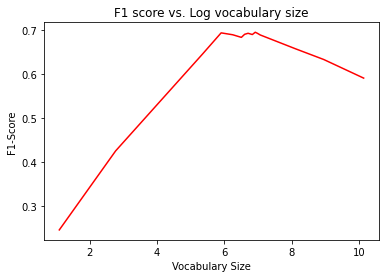

In [8]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0) 

    ### STUDENT START ### 
    # Initializing the count vectorizer:
    vectorizer = CountVectorizer() 
    # Transforming the training and dev data: 
    X = vectorizer.fit_transform(train_data)
    Y = vectorizer.transform(dev_data)
    
    # Extracting the vocabulary: 
    vocab = np.array(vectorizer.get_feature_names())

    # Creating a dictionary of L2 and L1: 
    d = {'L2':[], 'L1':[], 'vocab_counts':[]}
    # For several L1 regularization strengths (same as from Part 3): 
    C_list = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 1000]
    
    for C in C_list:
        # Producing a Logistic Regression model using the L1 regularization strength: 
        model=LogisticRegression(penalty = 'l1', C = C, tol = .015, solver="liblinear")
        # Train on the transformed (i.e. CountVectorizer) training data: 
        model.fit(X,train_labels)
        # Evaluating on the transformed dev data: 
        predictions = model.predict(Y)
        # Calculating the f1 score for the models: 
        f1_score = metrics.f1_score(dev_labels, predictions, average='weighted') 
        # Printing out the f1 score associated with each C value: 
        print("L1 Logistic Regression with L1 Regularization Strength: " + str(C))
        print("F1-score: " + str(f1_score))
        # Adding the f1 score to the list of scores associated with the L1 model:
        d['L1'].append(f1_score)
        # Reducing the vocabulary to only those features that have at least one non-zero weight among the four categories:
        non_zeros=np.sum(model.coef_!=0,axis=0)!=0
        # Adding the sum of the features that have atleast one non-zero weight among the four categories to the vocabulary size: 
        d['vocab_counts'].append(np.sum(non_zeros))
        
    # Producing a new Logistic Regression model using the reduced vocabulary: 
    model=LogisticRegression(penalty='l2', C=0.5, tol = .015, solver ="liblinear")
    # Fitting the model on the training data based on the reduced vocabulary: 
    new_train_data = X[:,non_zeros]
    model.fit(new_train_data, train_labels)
    print('\n')
    # Initializing a new dev dataset based on the reduced vocabulary:
    new_dev_data =Y[:, non_zeros]
    # Evaluating on the transformed dev data: 
    predictions = model.predict(new_dev_data)
    # Calculating the f1 score for the model: 
    f1_score = metrics.f1_score(dev_labels, predictions, average='weighted')
    # Evaluating and showing the L1 regularization strength, vocabulary size, and f1 score associated with the new model:
    print("L2 Logistic Regression with L2 Regularization Strength: "+ str(0.5))
    print("F1-score: " + str(f1_score))
    print("Vocabulary size: " + str(len(d['vocab_counts'])))
    # Adding the f1 score to the list of scores associated with the L2 model: 
    d['L2'].append(f1_score) 
    
    # Showing a plot of f1 score vs. log vocabulary size: 
    # (Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary)
    plt.plot(np.log(d['vocab_counts']), d['L1'], color='red')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('F1-Score')
    plt.title('F1 score vs. Log vocabulary size')
    ### STUDENT END ###

Q6()

ANSWER: 

The performance of the model based on the reduced vocabulary is roughly similar to that of models based on the full vocabulary. It appears that the performance of the models with the full vocabulary increases with increasing C values up to a optimal point with a f1 score high of about 0.6955. On the other hand, the performance of the model with the reduced vocabulary is slightly lower but very close with a f1 score of 0.6875, with a difference of about 0.008 compared to the full vocabulary-based models. 

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def Q7():
    ### STUDENT START ###
    
    # using TfidfVectorizer and its .fit_transform method to transform the training and dev data to tf-idf form:
    tfidf = TfidfVectorizer()
    tfidf_train = tfidf.fit_transform(train_data)
    tfidf_dev = tfidf.transform(dev_data)
    
    # Producing a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100
    # Using LogisticRegression(C=100, solver="liblinear", multi_class="auto") to produce a logistic regression model: 
    model = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    # Training on the transformed training data:
    model.fit(tfidf_train, train_labels)
    # Evaluate on the transformed development data:
    predictions = model.predict(tfidf_dev)
    # Evaluating and showing the f1 score:
    print("f1 score: ", metrics.f1_score(dev_labels, predictions, average='weighted'))
    print('\n')
    
    
    # Using LogisticRegression's .predict_proba method to access predicted probabilities: 
    pred_probs = model.predict_proba(tfidf_dev)
    
    # Showing the 3 documents with highest R ratio:
    R_ratios = []
    # Iterating through the range of dev data labels:
    for item in range(len(dev_labels)):
        # Obtaining the numerator:
        max_pred_probs = pred_probs[item, predictions[item]]
        # Obtaining the denominator:
        pred_probs_correct = pred_probs[item, dev_labels[item]]
        # Appending to the list of R values based on the function R ratio = maximum predicted probability/predicted probability of correct label:
        R_ratios.append(max_pred_probs/pred_probs_correct)
             
    # Converting to numpy array and getting the R values sorted in descending order with indices of highest 3:
    indices = np.array(R_ratios).argsort()[-3:]
    # Printing out the respective R values for the documents: 
    for item in range(0, 3):
        print("Document with R Ratio of: " + str(sorted(R_ratios, reverse=True)[:3].pop(item)))
        # Accessing the text to print out the top 3 R ratio documents: 
        for index in indices:
            print(dev_data[index])
            print('\n')
    ### STUDENT END ###

Q7()

f1 score:  0.7597662427853104


Document with R Ratio of: 929.3579452198546

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...



Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.


I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copy

ANSWER: 

The TfidfVectorizer is different than the CountVectorizer because it represents a combination of the term-frequency count in the document as returned by the CountVectorizer as well as the log of the inverse of the frequency of it in the corpus, multiplied and normalized. In more logical terms, using the TfidfVectorizer acts like lowering the weights of the words that appear in many documents and increasing the weights of the words that do not appear in many documents. 

The R ratio describes the ratio of the maximum predicted probability, what the model predicted the highest likely label as, over the predicted probability of the correct label, what the model predicted the correct label as. The higher the R ratio, the more incorrect the predictions are, i.e. the worse the model performance is. 

The model is making mistakes such that it does not effectively recognize and analyze special characters like @*"-, which are commonly used on the internet. Moreover, the model is also unable to distinguish between athiesm and religion. For example, the one with the highest R ratio is interpreterd as grapgics due to the computer-generated text. In order to address this issue, we can include some more examples in the dataframe that provide a contexual basis for conversations associated with both athiesm and religion. In addition to this, one could also potentially employ some tools in topic modelling with strategic seed words in order to provide a basis for differentiation.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.